# Pysch 45: Emotional memory demo results

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import re
import string

sns.set(style='ticks', font_scale=1.5)

In [3]:
df = pd.read_csv('HITResultsFor3UEDKCTP9VQSZE86QJFHRRFFFRL7KU.csv', index_col=False)
ratings = pd.read_csv('valence_ratings.csv', index_col=False)

#### Number of participants

In [4]:
print 'There are data from ' +str(df.shape[0] - 1) + ' participants.'

There are data from 31 participants.


## Pull out important data from Turk output

In [5]:
def add_null_col(df, col_names):
    for col in col_names:
        df[col] = np.nan
    return df

In [6]:
dtrials = pd.DataFrame()
drecall = pd.DataFrame()
predicate = lambda x:x not in string.punctuation

condition_list = ['pos', 'neg', 'neut']
df = add_null_col(df, condition_list)

for sub in df.iterrows():
        
    index = sub[0]
    row = sub[1]
    
    # extract trial data, for serial position
    trial_count = len(eval(df.ix[index]['Answer 1'])['thisList'])
    dsub = pd.DataFrame([eval(df.ix[index]['Answer 1'])['thisList'],
                         eval(df.ix[index]['Answer 1'])['theseResults']],
                         index=['word', 'retrieved']).T
    dsub.loc[:,'retrieved'] = dsub.retrieved.astype(int)
    dsub['subid'] = index
    dsub['serial_pos'] = np.arange(1,trial_count+1)
    dtrials = dtrials.append(dsub, ignore_index=True)
    
    # extract free recall order data
    recall_order = eval(df.ix[index,'Answer 1'])['thisRetrieval']
    recall_order = re.split('; |, |\n|\t| |', recall_order) # strip various ways
    recall_order = [filter(predicate, recall) for recall in recall_order] # remove punctuation
    recall_order = [recall.lower() for recall in recall_order] # convert to lowercase
    recall_order = filter(lambda x: x != '', recall_order) # remove empty words
    recall_order = filter(lambda x: x in ratings.word.values, recall_order) # remove FAs
    dsub = pd.DataFrame()
    dsub['word'] = pd.Series(recall_order)
    dsub['subid'] = index
    dsub['recall_order'] = np.arange(1,len(recall_order)+1)
    dsub['word_status'] = 'word'
    dsub.ix[len(recall_order)-1, 'word_status'] = 'last'
    drecall = drecall.append(dsub, ignore_index=True)
    
    for cond in ['pos', 'neg', 'neut']:
        df.ix[index, cond] = eval(row['Answer 1'])['num' + cond]        


In [7]:
data = pd.DataFrame(df.loc[:,['pos', 'neg', 'neut']].stack().reset_index())
data.rename(columns={'level_0': 'subid', 
                     'level_1': 'valence', 
                     0: 'count'}, inplace=True)
data['proportion'] = data['count'].apply(lambda x: x/15)
data.head()

,subid,valence,count,proportion
0,0,pos,1,0.066667
1,0,neg,1,0.066667
2,0,neut,2,0.133333
3,1,pos,5,0.333333
4,1,neg,5,0.333333


In [8]:
data = data.loc[data.subid != 0] #remove "pilot" data
dtrials = dtrials.loc[dtrials.subid != 0].reset_index() #remove "pilot" data
drecall = drecall.loc[drecall.subid != 0].reset_index() #remove "pilot" data

dtrials = dtrials.merge(ratings)

### Do participants remember more emotional than neutral words?

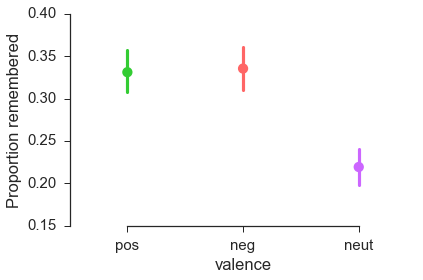

In [10]:
p = sns.factorplot(x='valence', y='proportion', 
                   hue='valence', units='subid', ci=68,
                   data=data, aspect=1.5,
                   palette=['#33cc33', '#ff6666', '#cc66ff'])

p.set_ylabels('Proportion remembered')
sns.despine(trim=True)

## Most commonly retrieved words

In [11]:
top_words = dtrials.groupby(['word']).mean().reset_index().sort('retrieved', 
                                                               ascending=False)
top_words.loc[top_words['retrieved'] > .45, ['word', 'retrieved']]

,word,retrieved
32,rape,0.774194
22,love,0.612903
24,mother,0.580645
39,suicide,0.483871
31,rainbow,0.483871
19,laughter,0.451613
20,leprosy,0.451613
17,kiss,0.451613


# Serial position effect

### Categorical analysis: 
  

- Primacy: First 5 words
- Middle: Middle 35 words
- Recency: Last 5 words

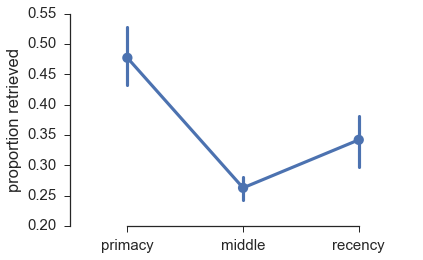

In [12]:
dtrials['serial_category'] = 'middle'
dtrials.loc[dtrials.serial_pos < 6, 'serial_category'] = 'primacy'
dtrials.loc[dtrials.serial_pos > 40, 'serial_category'] = 'recency'

data = dtrials.groupby(['subid', 'serial_category']).mean().reset_index()

p = sns.factorplot(x='serial_category', order=['primacy', 'middle', 'recency'],
                   y='retrieved', aspect=1.5,
                   units='subid', ci=68, data=data)

p.set_xlabels('')
p.set_ylabels('proportion retrieved')
sns.despine(trim=True)

### Is probability of recalling words in the middle of the list higher if the word is emotional?

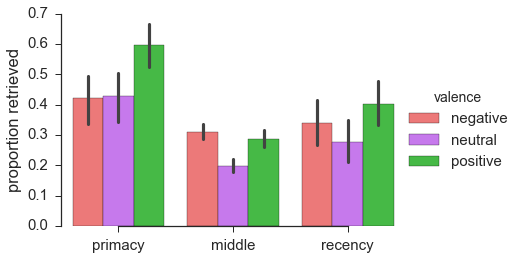

In [13]:
data = dtrials.groupby(['subid', 'serial_category', 'valence']).mean().reset_index()

p = sns.factorplot(x='serial_category', 
                   order=['primacy', 'middle', 'recency'],
                   y='retrieved', aspect=1.5, hue='valence',
                   units='subid', ci=68, data=data, kind='bar', 
                   palette=['#ff6666', '#cc66ff', '#33cc33'])

p.set_xlabels('')
p.set_ylabels('proportion retrieved')
sns.despine(trim=True)

## Serial position function

### Smoothed serial position

In [14]:
dtrials.index = dtrials.serial_pos

In [15]:
def bin_series(vector, smoothing_factor):
    unique_points = vector.max()
    bins = np.linspace(0, unique_points, unique_points/smoothing_factor)
    binned_vec = np.digitize(vector, bins)
    
    return binned_vec

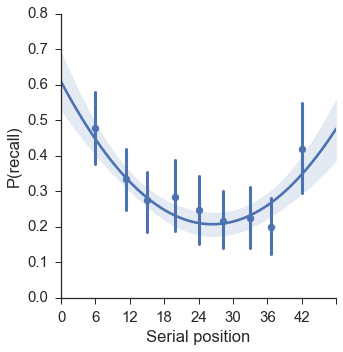

In [16]:
smoothing_factor = 3

dserial = dtrials
dserial['serial_pos_bin'] = bin_series(dserial.serial_pos, smoothing_factor)
dserial = dserial.groupby(['subid', 'serial_pos_bin']).mean().reset_index()

p = sns.lmplot(x='serial_pos_bin', y='retrieved',
                units='subid', ci=68, x_bins=9,
                order=2, #lowess=True, 
                data=dserial)

plt.xlabel('Serial position')
plt.ylabel('P(recall)')
p.set_xticklabels(np.array([0,2,4,6,8,10,12,14]) * smoothing_factor)

sns.despine(trim=True)

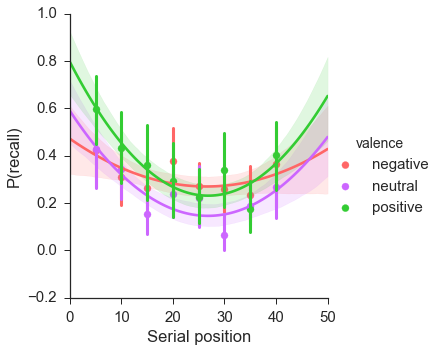

In [17]:
smoothing_factor = 5

dserial = dtrials
dserial['serial_pos_bin'] = bin_series(dserial.serial_pos, smoothing_factor)
dserial = dserial.groupby(['subid', 'serial_pos_bin', 'valence']).mean().reset_index()

p = sns.lmplot(x='serial_pos_bin', y='retrieved', hue='valence',
                units='subid', ci=68, x_bins=9,
                order=2, palette=['#ff6666', '#cc66ff', '#33cc33'],
                data=dserial)

plt.xlabel('Serial position')
plt.ylabel('P(recall)')

p.set_xticklabels(np.array([0,2,4,6,8,10]) * smoothing_factor)

sns.despine(trim=True)

### Raw serial position function

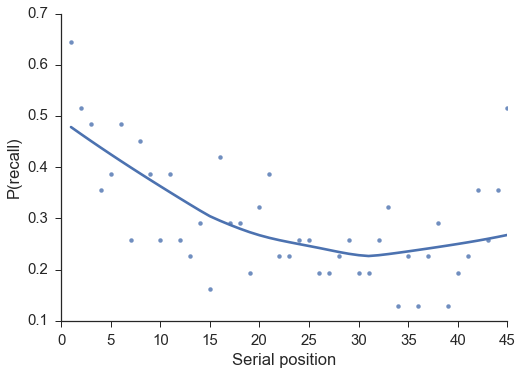

In [18]:
dserial = dtrials.groupby(['serial_pos']).mean().reset_index()

p = sns.regplot(x='serial_pos', y='retrieved', 
                lowess=True,
                data=dserial)

plt.locator_params(axis='x',nbins=15)
plt.xlim(0,dtrials.serial_pos.max())
plt.xlabel('Serial position')
plt.ylabel('P(recall)')

sns.despine(trim=True)

## Effect of valence/arousal on retrieval of each word

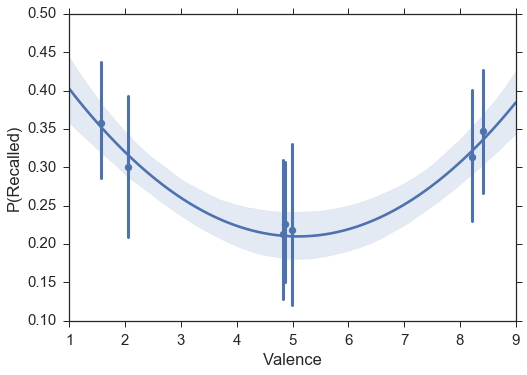

In [19]:
data = dtrials.groupby(['subid', 'word']).mean().reset_index()
data.head()

p = sns.regplot(x='valence_mean', y='retrieved', ci=68, x_bins=7,
                units='subid',
                data=data, order=2)
p.set_xlabel('Valence')
p.set_ylabel('P(Recalled)')

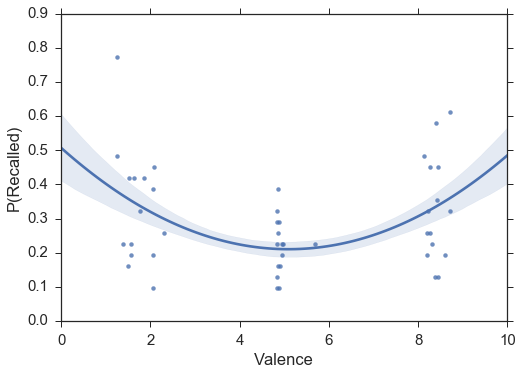

In [20]:
data = dtrials.groupby(['word']).mean().reset_index()
data.head()

p = sns.regplot(x='valence_mean', y='retrieved', ci=68, 
                data=data, order=2)
p.set_xlabel('Valence')
p.set_ylabel('P(Recalled)')

In [27]:
dtrials.head()

,index,word,retrieved,subid,serial_pos,valence,valence_mean,arousal_mean,serial_category,serial_pos_bin
serial_pos,,,,,,,,,,
1,45,slaughter,0,1,1,negative,1.64,6.77,primacy,1
45,134,slaughter,0,2,45,negative,1.64,6.77,recency,9
21,155,slaughter,1,3,21,negative,1.64,6.77,middle,4
1,180,slaughter,0,4,1,negative,1.64,6.77,primacy,1
16,240,slaughter,0,5,16,negative,1.64,6.77,middle,3


## Retrieval context effects

Are participants more likely to recall words of a simialar valence in a row?

In [22]:
data = drecall.merge(ratings).sort('index')
data['valence_next'] = data.valence.shift(-1) # shift back one word

# Limit to just words where recall another one after (i.e., not last recall attempt)
data = data.loc[data.word_status == 'word']

# Get counts, and convert to proportion
data = data.groupby(['subid', 'valence', 'valence_next']).count().reset_index()
data = data.pivot_table(values='word', index=['subid', 'valence'], columns=['valence_next']).fillna(0)
data['total_recall'] = data.sum(axis=1)
data = data.div(data.total_recall, axis='index') # proportion of recalled for this valence
data.drop('total_recall', axis=1, inplace=True)

# reformat dataframe
data = pd.DataFrame(data.stack()).reset_index()
data = data.rename(columns={0: 'transition probability'})

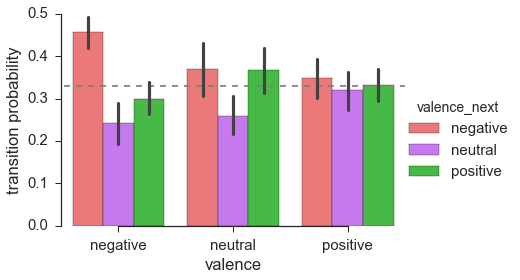

In [23]:
sns.factorplot(x='valence', y='transition probability', hue='valence_next', 
               kind='bar', data=data, units='subid', ci=68,
               aspect=1.5, 
               palette=['#ff6666', '#cc66ff', '#33cc33'])
plt.hlines(.33, -1,3, linestyles='dashed', colors='gray')
sns.despine(trim=True)